# Туториал по нейросетевому подходу к численному интегрированию функции одной переменной

__Задача__: использовать нейросеть архитектуры MLP для численного интегрирования функции одной переменной.

__Использованные источники__: 

* Lloyd S., Irani R. A., Ahmadi M. Using neural networks for fast numerical integration and optimization //
IEEE Access. — 2020. — Т. 8. — С. 84519—84531.
* [Документация по PyTorch](https://pytorch.org/docs/stable/index.html)
* [Документация по NumPy](https://numpy.org/doc/)
* [Документация по Mpmath](https://mpmath.org/doc/current/index.html)
* [Документация по Matplotlib](https://matplotlib.org/stable/index.html)
* [Документация по scikit-learn](https://scikit-learn.org/stable/)

## Немного теории

Численным интегралом функции одной переменной называют выражение вида:

$ I(f) = \int_{a}^{b} dx \{f(x)\} $ (1) 

В некоторых случаях неопределенный интеграл функции $f(x)$ может быть получен аналитически,
и тогда определенный интеграл можно выразить как 

$\int_{a}^{b} dx \{f(x)\} = F(b) - F(a)$, (2)

где $F(x) = \int dx \{f(x)\}$,
но иногда аналитическую форму сложно или невозможно получить и тогда прибегают к помощи численных 
методов.

Применить нейросетевой подход возможно образом, описаным далее.

__1. Нейросеть можно представить аналитически__

Нейросеть, так как она является лишь набором математических операций над числами в определенной 
последовательности, можно представить как некоторую функцию $\hat{f}(X)$, которая может быть 
задана аналитически:

$ \hat{f}(X) = b^{(2)} + W^{(2)T}\phi(b^{(1)}+W^{(1)}X) $ (3)

-- такое аналитическое представление имеет многослойный перцептрон (MLP) с одним скрытым слоем и 
функцией активации только на скрытом слое, где

$ W^{(1)}, W^{(2)} $ - векторы весов нейросети,

$ b^{(1)}, b^{(2)} $ - векторы смещений нейросети.

$ X $ - множество входных параметров (для функции одной переменной $|X| = 1$ и в дальнейшем будет 
указываться как $x$),

$ \phi(•) $ - функция активации скрытого слоя.

__2. Возможность аналитического интегрирования нейросети__

Приведенное выше аналитическое представление нейросети в зависимости от вида функции активации 
$ \phi $ возможно интегрировать аналитически. Это даёт возможность получить определенный интеграл 
нейросети $ \hat{f}(x) $ по формуле (2).

Представим нейросеть с помощью сумм:

$ \hat{f}(x) = b^{(2)} + \sum_{j=1}^{k}w_j^{(2)}\phi(b_j^{(1)}+w_{1j}^{(1)}x) $ (4),

где $ k $ - число нейронов скрытого слоя.

В данной архитектуре воспользуемся функцией активации *логистическая сигмоида*:

$ \phi(•) = \frac{1}{1 + e^{-(•)}} $ (5)
 
Для того, чтобы облегчить интегрирование нейросети воспользуемся выражением 
полилогарифма 0-го порядка и получим интеграл нейросети $\hat{f}(x)$, обозначив полученный интеграл 
$ \hat{I}(f) $:

$ \hat{I}(f) = \int_{\alpha}^{\beta} dx [b^{(2)} + \sum_{j=1}^{k}w_j^{(2)}\phi(b_j^{(1)}+w_{1j}^{(1)}x)] = $

$ = b^{(2)}(\beta - \alpha) + \sum_{j=1}^{k}w_{j}^{(2)}[(\beta - \alpha) + \frac{\Phi_{j}}{w_{1j}^{(1)}} ] $ (6.1)

$ \Phi_j = Li_1(-exp[-b_j^{(1)} - w_{1j}^{(1)}\alpha]) - Li_1(-exp[-b_j^{(1)} - w_{1j}^{(1)}\beta]) $ (6.2)

Как видно выше, формулы (6.1) и (6.2) позволяют, зная веса и смещения нейросети получить значение определенного 
интеграла нейросети $ \hat{f}(x) $.

Как же это может помочь нам в численном интегрировании нашей изначальной функции?

__3. Нейросетевое численное интегрирование__

Давайте попробуем приблизить значения функций $ f(x) $ нейросетью $ \hat{f}(x) $. Зная вид функции $ f(x) $ и 
её область определения $ A $ мы имеем возможность создать обучающее и тестовое множество 
$ TRAIN = \{ (x, y) | x \in A, y = f(x) \},$ $TEST = \{ (x, y) | x \in A, y = f(x) \}$ и провести 
процедуру обучения нейросети $ \hat{f}(x) $.

После достижения удовлетворяющей нас точности мы можем предположить, что данная нейросеть $ \hat{f}(x) $ 
приближает $ f(x) $, то есть, проще говоря, для любого $ x \in A $ значение 
$ \hat{f}(x) $ достаточно близко значению $ f(x) $:

$ |\hat{f}(x) - f(x)| < \epsilon $,

где $ \epsilon $ - удовлетворяющая требованиям задачи погрешность.

Таким образом, $ \hat{f}(x) $ "ведёт себя" так же как и изначальная $ f(x) $, а значит интеграл $ \hat{I}(f) = \int_{a}^{b}dx\{\hat{f}(x)\} $ будет близок по значению искомому интегралу $ I(f) = \int_{a}^{b}dx\{f(x)\} $:

$ |\hat{I}(f) - I(f)| < \varepsilon $,

где $ \varepsilon $ - удовлетворяющая требованиям задачи погрешность.

Но пора перейти к практике и испробовать данный подход!

## Импорт необходимых библиотек

* PyTorch - работа с нейросетью.
* NumPy - работа с массивами данных и операциями над ними.
* Matplotlib - визуализация данных.
* Mpmath - необходим для имплементации полилогарифма.
* scikit-learn - необходим для создания датасета для дальнейшего обучений нейросети.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

import numpy as np

import matplotlib.pyplot as plt

from mpmath import polylog

from sklearn.model_selection import train_test_split

## Создание датасета
### Функция $f(x)$ и функция-генератор датасета

Будем тренировать модель аппроксимировать простую функцию $ f(x) = cos(x) $.

Определим функцию $ f(x) $ и функцию-генератор датасета.

In [2]:
def f_cos(x):
    """
        Функция одной переменной cos(x).
        
        @param переменной функции 
               (в силу нестрогой типизаци в Python может быть передан и вектор переменных) 
        
        @returns значение функции для данной переменной (данных переменных)
    """
    return np.cos(x)

In [3]:
def generate_data(func, size=100):
    """
        Функция-генератор датасета.
        
        @param func функция одной переменной
        @param size размер датасета (по умолчанию 100)
        
        @returns тензор переменных х и тензор функций y
    """
    x = torch.linspace(0, 1, size).unsqueeze(1) # вектор-столбец случайных (равномерное распределение) 
                                                # переменных в отрезке [0, 1]
    y = func(x) # вектор значений функции
    
    return x, y

In [4]:
data = generate_data(f_cos, 10)
data

(tensor([[0.0000],
         [0.1111],
         [0.2222],
         [0.3333],
         [0.4444],
         [0.5556],
         [0.6667],
         [0.7778],
         [0.8889],
         [1.0000]]),
 tensor([[1.0000],
         [0.9938],
         [0.9754],
         [0.9450],
         [0.9028],
         [0.8496],
         [0.7859],
         [0.7125],
         [0.6303],
         [0.5403]]))

### Создание датасета для нейронной сети

Теперь необходимо воспользоваться созданными функциями, чтобы создать объект тренировочную и тестовую выборку.
(В данном конкретном случае валидация на этапе обучения выполняться не будет.)

In [5]:
X, Y = generate_data(f_cos, 10000) # датасет из параметров и значений функций

In [6]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2) # разделение на тренировочные 
                                                                           # и тестовые выборки

x_train.shape, y_train.shape, x_test.shape, y_test.shape # размерности выборок

(torch.Size([8000, 1]),
 torch.Size([8000, 1]),
 torch.Size([2000, 1]),
 torch.Size([2000, 1]))

На данном этапе мы имеем созданный набор данных для функции __cos(x)__.

## Создание модели

Теперь создадим модель нейросети, которая будет учиться оценивать данную функцию одной переменной.
Необходимо определить: 
* её архитектуру,
* функцию обучения,
* функцию тестирования.

### Архитектура нейросети

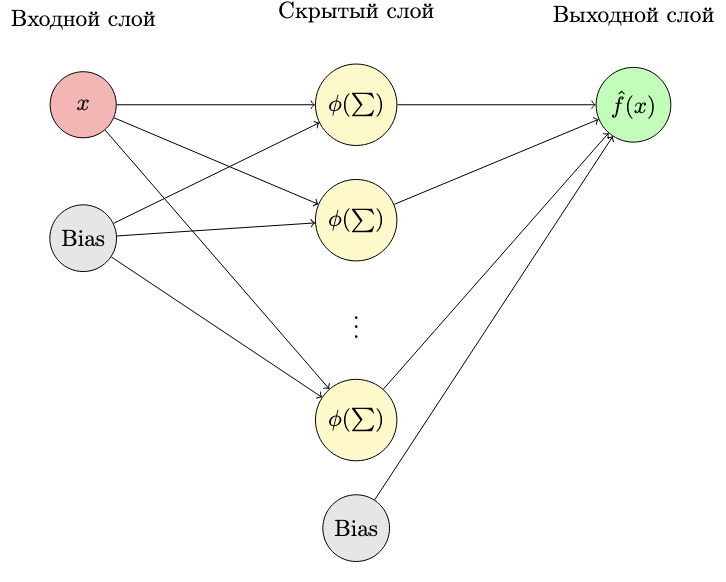

### Создание архитектуры нейросети

In [7]:
class MLP(nn.Module):
    """
        Нейросеть, которая будет обучаться приближать функцию одной переменной.
        
        Нейросеть имеет архитектуру:

        Входной слой (1 нейрон для переменной функции + смещение, линейная функция активации)
        Скрытый слой (произвольное количество нейронов + смещение, функция активации - сигмоида)
        Выходной слой (1 нейрон для приближенного значения функции, линейная функция активации)
    """
    def __init__(self, hidden_size):
        """
            Конструктор для нейросети.
            @param self        нейросеть (необходим для включения в класс)
            @param hidden_size размер скрытого слоя (размеры входного и выходного слоёв равны одному
                               в рамках данной задачи, так как у функции одна переменная и 
                               задача сводится к описанию функции, то есть числа, скаляра).
        """
        super(MLP, self).__init__()
        self.input_hidden_layer = nn.Linear(1, hidden_size) # инициализация входного и скрытого слоя, 
                                                     # размеры: 1 --> размер скрытого слоя
        self.sigmoid_activation = nn.Sigmoid() # инициализация функции активации скрытого слоя
        self.output_layer = nn.Linear(hidden_size, 1) # инициализация выходного слоя, 
                                                      # размеры: размер скрытого слоя --> 1
    
    def forward(self, x):
        """
            Функция распространения данных через нейросеть вперёд.
           
            @param self   нейросеть (необходим для включения в класс)
            @param x      данные
           
            @returns выход в выходном нейроне
        """
        x = self.input_hidden_layer(x) # данные прошли входной слой и аккумулирвоаны в скрытом слое
        x = self.sigmoid_activation(x) # данные прошли функцию активации скрытого слоя
        x = self.output_layer(x) # данные прошли выходной слой
        
        return x

### Создание функции обучения нейросети

In [8]:
def train_model(model, criterion, optimizer, x_train, y_train, epochs):
    """
        Функция обучения нейросети.
        @param model
        @param criterion функция потерь
        @param optimizer модель оптимизации
        @param x_train   тренировочный набор переменных
        @param y_train   тренировочный набор истинных значений функций
        @param epochs    количество эпох обучения
    """
    loss_history = [] # история обучения (изменения функции потерь)
    for epoch in range(epochs):
        predictions = model(x_train) # все переменные проводятся через нейросеть 
                                     # и формируются предскзания значений функции
        loss = criterion(predictions, y_train) # вычисляется функция потерь на данной эпохе

        optimizer.zero_grad() # обнуляются градиенты перед обратным распространением ошибки
        loss.backward() # обратное распространение ошибки
        optimizer.step() # шаг оптимизации - обновление параметров модели 

        loss_history.append(loss.item()) # запись текущей функции потерь

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.10f}') # вывод информации об обучении
    
    return loss_history # возвращается история обучения

### Создание функции тестирования нейросети

In [9]:
def test_model(model, criterion, x_test, y_test):
    """
    Функция тестирования нейросети.
    @param model      обученная модель
    @param criterion  функция потерь
    @param x_test     тестовый набор переменных
    @param y_test     тестовый набор истинных значений функций
    """
    with torch.no_grad():  # отключение расчета градиентов 
                           # (расчет градиентов может происходить по умолчанию 
                           # даже без использования их потом, что излишне нагружает память)
        predictions = model(x_test)  # тестовые переменные проводятся через обученную модель
        loss = criterion(predictions, y_test)  # вычисляется функция потерь для тестового набора

    # Возвращаем вычисленную функцию потерь
    return loss.item()  # Возвращаем скалярное значение ошибки

Мы разработали архитектуру нейросети и необходимые функции для работы с ней. 
Теперь пора воспользоваться созданым функционалом для вычисления интеграла cos(x).

## Применение нейросетевого подхода
### Задание гиперпараметров

In [10]:
hidden_size = 20 # число нейронов скрытого слоя
learning_rate = 0.001 # скорость обучения
num_epochs = 10000 # число эпох

### Создание модели

In [11]:
model = MLP(hidden_size) # создание модели
model # вывод упрощенного описания модели

MLP(
  (input_hidden_layer): Linear(in_features=1, out_features=20, bias=True)
  (sigmoid_activation): Sigmoid()
  (output_layer): Linear(in_features=20, out_features=1, bias=True)
)

Из описания инициализированной модели видно, что она состоит из трёх слоёв с 
* 1 нейроном в входном слое,
* 20 нейронами в скрытом слое и функцией активации *сигмоида*,
* 1 нейроном в выходном слое,
* в первом и втором слое присуствует смещение.

Как будет видно ниже, в более подробном описании, у нейросети __61 параметр__, из которых:
* (1 входной нейрон + 1 входное смещение) * 20 скрытых нейронов = __40 параметров__ между входным и скрытым слоями,
* 20 скрытых нейронов + 1 скрытое смещение = __21 параметр между__ скрытым и выходным слоями.
Все из этих параметров обучаемые.

In [12]:
summary(model, (1,)) # подробное описание модели

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]              40
           Sigmoid-2                   [-1, 20]               0
            Linear-3                    [-1, 1]              21
Total params: 61
Trainable params: 61
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


### Обучение модели

In [13]:
criterion = nn.MSELoss() # функция потерь - среднеквадратичная ошибка
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # алгоритм оптимизации Adam

history = train_model(model, criterion, optimizer, x_train, y_train, num_epochs) # запуск обучения
                                                                                 # процесс обучения записывается 
                                                                                 # в переменной history

Epoch [100/10000], Loss: 0.1571203321
Epoch [200/10000], Loss: 0.0149002196
Epoch [300/10000], Loss: 0.0120327184
Epoch [400/10000], Loss: 0.0112743368
Epoch [500/10000], Loss: 0.0104530426
Epoch [600/10000], Loss: 0.0095900092
Epoch [700/10000], Loss: 0.0087069068
Epoch [800/10000], Loss: 0.0078232903
Epoch [900/10000], Loss: 0.0069570364
Epoch [1000/10000], Loss: 0.0061244182
Epoch [1100/10000], Loss: 0.0053399489
Epoch [1200/10000], Loss: 0.0046160328
Epoch [1300/10000], Loss: 0.0039625294
Epoch [1400/10000], Loss: 0.0033862712
Epoch [1500/10000], Loss: 0.0028907403
Epoch [1600/10000], Loss: 0.0024759071
Epoch [1700/10000], Loss: 0.0021383837
Epoch [1800/10000], Loss: 0.0018718807
Epoch [1900/10000], Loss: 0.0016679311
Epoch [2000/10000], Loss: 0.0015167894
Epoch [2100/10000], Loss: 0.0014083593
Epoch [2200/10000], Loss: 0.0013330118
Epoch [2300/10000], Loss: 0.0012821915
Epoch [2400/10000], Loss: 0.0012487690
Epoch [2500/10000], Loss: 0.0012271457
Epoch [2600/10000], Loss: 0.001213

#### Визуализация процесса обучения

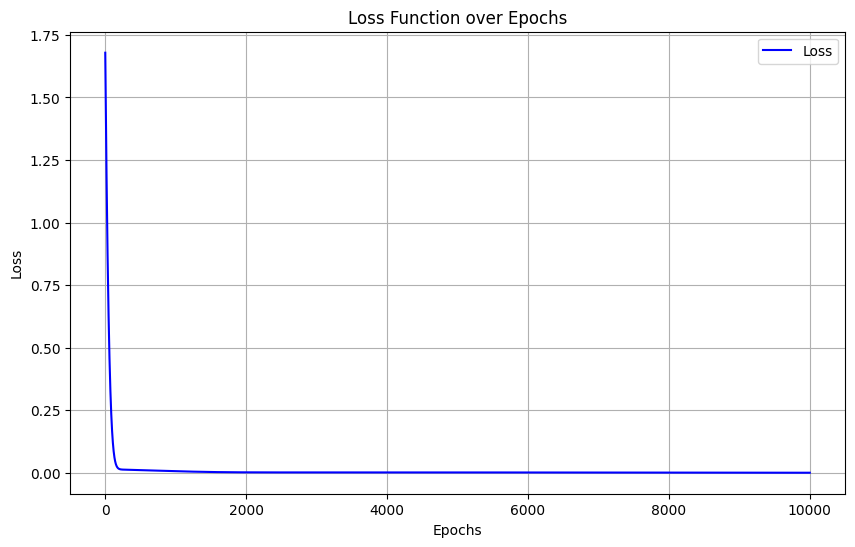

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(history, label='Loss', color='b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function over Epochs')
plt.legend()
plt.grid(True)
plt.show()

### Тестирование модели

In [15]:
test_loss = test_model(model, criterion, x_test, y_test)
print(f"Test Loss: {test_loss:.10f}")

Test Loss: 0.0000064450


### Извлечение параметров модели

Теперь необходимо извлечь из нейросети её веса и смещения для того, чтобы подставить в качестве
параметров в формулу (6.1). 

In [16]:
def extract_model_params(model):
    """
        Функция извлечения параметров нейросети.
        @param model модель, из которой необходимо извлеч параметры
        @returns 4 объекта типа numpy.array: смещения 1-го слоя, веса 1-го слоя,
                 смещения 2-го слоя, веса 2-го слоя
    """
    # detach() - возвращает выбранный параметр, numpy() конвертирует в формат numpy.array,
    # flatten() для весов преобразует векторы-столбцы в векторы-строки.
    b1 = model.input_hidden_layer.bias.detach().numpy() 
    w1 = model.input_hidden_layer.weight.detach().numpy().flatten()
    b2 = model.output_layer.bias.detach().numpy() 
    w2 = model.output_layer.weight.detach().numpy().flatten()
    
    return b1, w1, b2, w2

In [17]:
b1, w1, b2, w2 = extract_model_params(model)
b1.shape, w1.shape, b2.shape, w2.shape # извлечено 20 весов и смещений между входным и скрытым слоями
                                       # 20 весов и 1 смещение между скрытым и выходным слоями

((20,), (20,), (1,), (20,))

## Функция численного интегрирования

Выразим формулы (6.1) и (6.2) в качестве функции get_NN_analytical_integral().

In [18]:
def get_NN_analytical_integral(alpha, beta, b1, w1, b2, w2):
    """
        Функция, реализующая метод численного интегрирования функции одной переменной
        на основе параметров нейросети. Реализует формулы (6.1) и (6.2).

        @param alpha нижняя граница интегрирования
        @param beta  верхняя граница интегрирования
        @param b1    смещения между входным и скрытым слоями
        @param w1    веса между входным и скрытым слоями
        @param b2    смещения между скрытым и выходным слоями
        @param w2    веса между скрытым и выходным слоями

        @returns численный интеграл на основе параметров нейросети.
    """
    def Phi_j(alpha, beta, b1_j, w1_j):
        """
            Вложенная функция, реализующая разность полилогарифмов (6.2).

            @param alpha нижняя граница интегрирования
            @param beta  верхняя граница интегрирования
            @param b1_j  j-е смещение между входным и скрытым слоями
            @param w1_j  j-тый вес между входным и скрытым слоями

            @returns разность полилогарифмов (6.2)
        """
        term_alpha = polylog(1, -np.exp(-b1_j - w1_j * alpha)) # расчет первого полилогарифма 1-го порядка
        term_beta = polylog(1, -np.exp(-b1_j - w1_j * beta)) # расчет второго полилогарифма 1-го порядка
        
        return term_alpha - term_beta # результат - разность первого и второго полилогарифмов

    integral_sum = 0 # сумма интеграллов 
    
    for w2_j, w1_j, b1_j in zip(w2, w1, b1):
        phi_j = Phi_j(alpha, beta, b1_j, w1_j) # рассчет разности полилогарифмов (6.2)
        integral_sum += w2_j * ((beta - alpha) + phi_j / w1_j) # аккумулирование интегралла для суммы в (6.1)
    
    return b2 * (beta - alpha) + integral_sum # результат полная формула численног метода (6.1)

### Численное интегрирования

__Теперь всё готово для численного интегрирования.__ Проведём испытание на 5 отрезках интегрирования
и определим, насколько нейросетевые численные интегралы (будем отсылаться к ним NNI) отличаются от истинных интегралов нашей функции (будем отсылаться к ним TI).

Узнать истинные определенные интегралы очень просто, причем с максимально-возможной точностью: 

$ \int cos(x)dx = sin(x) + C $, значит 

$ \int_{\alpha}^{\beta}cos(x)dx = sin(\beta) - sin(\alpha) $.

In [19]:
alphas = [0, 0.2, 0.5, 0.7, 0.9] # нижние границы интегрирования
betas = [1, 0.4, 0.6, 0.9, 1.1] # верхние границы интегрирования

In [20]:
NNI = [] # нейросетевые интегралы
TI = [] # истинные интегралы

for alpha, beta in zip(alphas, betas): # цикл по границам интегрирования
    NNI.append(float(get_NN_analytical_integral(alpha, beta, b1, w1, b2, w2)[0])) # рассчет NNI для данных границ
    TI.append(np.sin(beta) - np.sin(alpha)) # рассчет TI для данных границ

И результаты:

In [21]:
errors = []

for i in range(len(NNI)): 
    print(f"Для α = {float(alphas[i]):.1f}, β = {float(betas[i]):.1f}\n\tNNI = {float(NNI[i]):.6f} и \n\t TI = {float(TI[i]):.6f}")
    error = np.abs(NNI[i] - TI[i])
    print(f"Ошибка составила {float(error):.6f}\n")
    errors.append(error)

print(f"Средняя ошибка составила {float(sum(errors) / len(errors)):.6f}")

Для α = 0.0, β = 1.0
	NNI = 0.841454 и 
	 TI = 0.841471
Ошибка составила 0.000017

Для α = 0.2, β = 0.4
	NNI = 0.190909 и 
	 TI = 0.190749
Ошибка составила 0.000160

Для α = 0.5, β = 0.6
	NNI = 0.085177 и 
	 TI = 0.085217
Ошибка составила 0.000040

Для α = 0.7, β = 0.9
	NNI = 0.138622 и 
	 TI = 0.139109
Ошибка составила 0.000488

Для α = 0.9, β = 1.1
	NNI = 0.109976 и 
	 TI = 0.107880
Ошибка составила 0.002095

Средняя ошибка составила 0.000560


Таким образом нам удалось применить нейросетевой подход для интегрирования функции 
одной переменной $ f(x) = cos(x) $ и представленная, относительно наивная имплементация
позволила обеспечить точность в среднем 3 знака после запятой.